# Setting up an authenticated connection for Open Energy

This notebook follows the [setup instructions](https://icebreakerone.github.io/open-energy-python-infrastructure/) for using the Open Energy Infrastructure Support Python library to access Shared datasets in the Open Energy ecosystem. 

Shared data is one of the [three classes of data](https://icebreakerone.org/open-shared-closed/) (Open, Shared, Closed) in the Open Energy ecosystem, and denotes data that may be used by members of the Open Energy ecosystem subject to conditions set by the data owner.

When you have configured your key and certificate you are ready to use the [Open Energy Shared Dataset Retrieval Example](https://colab.research.google.com/github/icebreakerone/open-energy-python-infrastructure/blob/main/examples/jupyter/open_dataset_retrieval.ipynb).

## Register with Open Energy

Organisations that wish to access shared data must register with Open Energy. Instructions for registration are in [this guide (beta)](https://docs.google.com/document/d/1sypYWTeLFSFyfO_zTW6xKCWnao9gKjAo2JHZZIPs2xI/edit). Once your account is set up, you can log in to the [portal](https://web.directory.energydata.org.uk/) to create and manage the certificates needed to access shared data. The rest of this notebook walks through that process.

## Install Open Energy Support

In [ ]:
!pip install ib1.openenergy.support
!oe_install_cacerts

## Find your organisation on the portal

When you log into the [portal](https://web.directory.energydata.org.uk/) you will see a page with the organisations you have access to. If you select one, you can see its information on the directory.

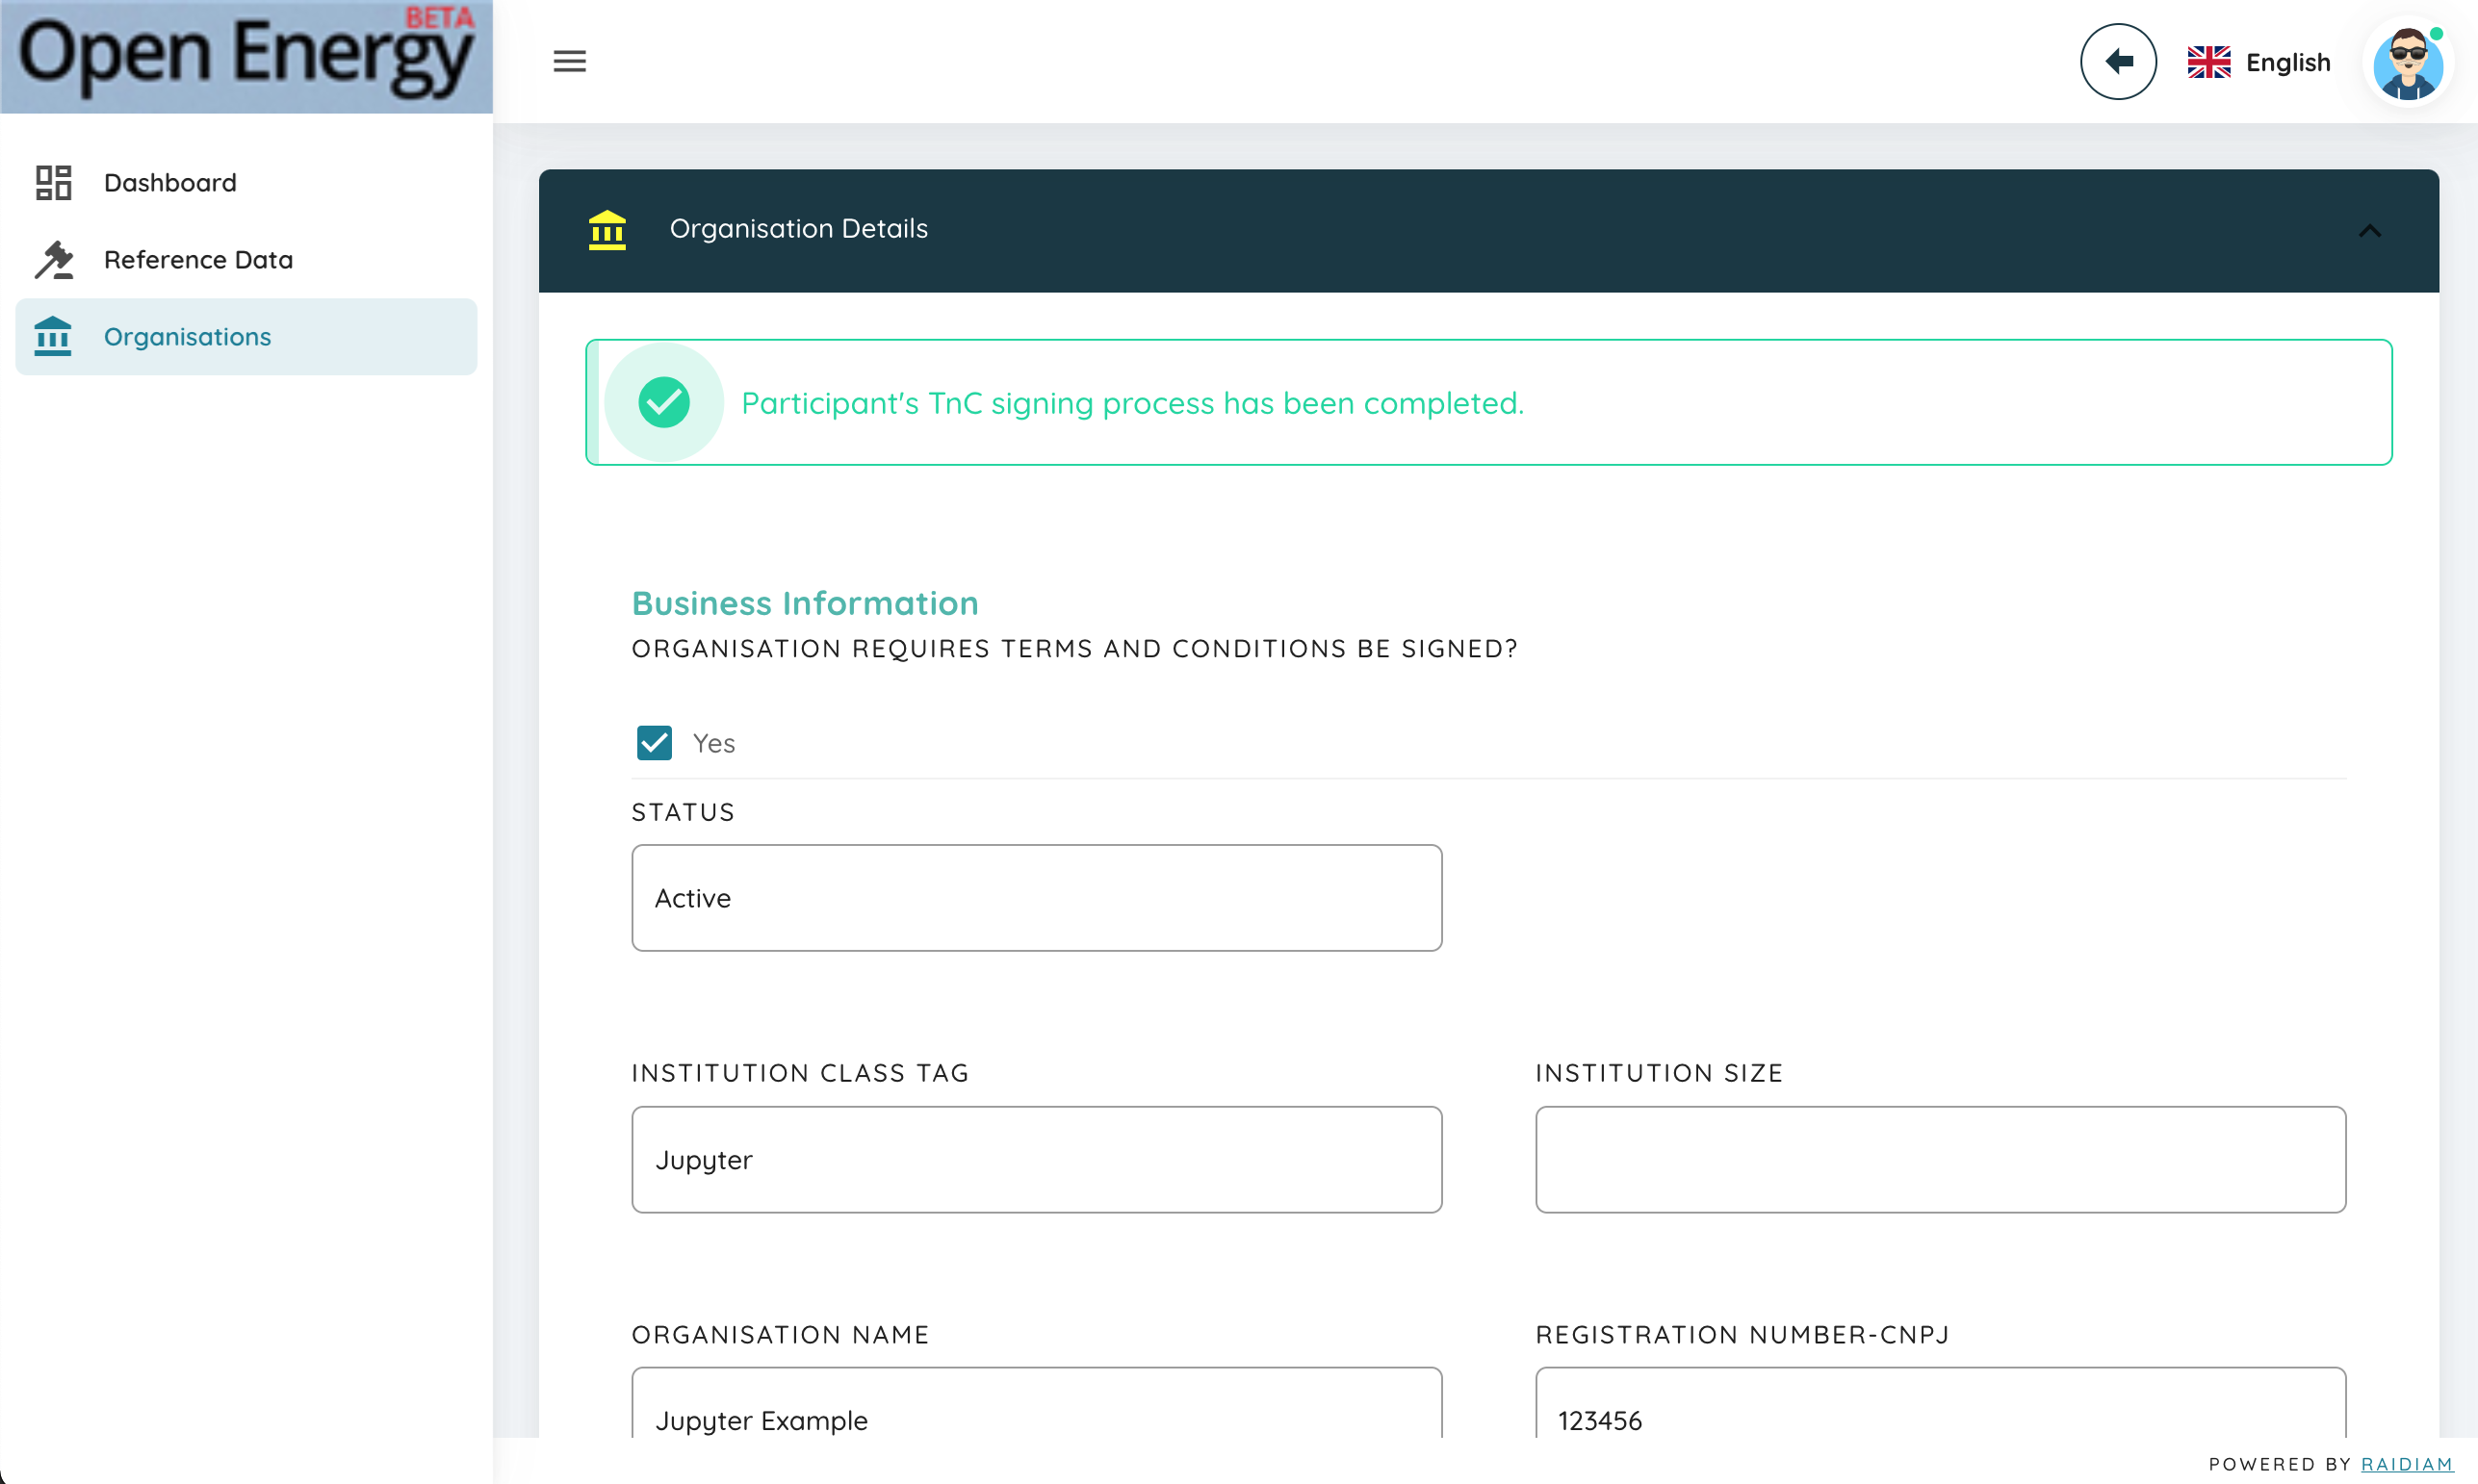

Make a note of your Organisation ID as you will need it later

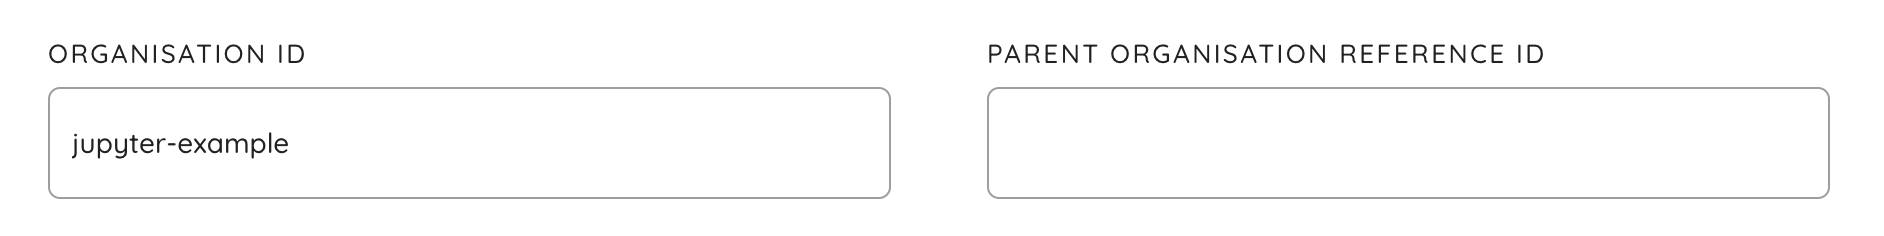

## Create a Software Statement

A Software Statement is an entry on the directory that corresponds to a client software package (an app or platform). It encapsulates Open Energy's authorization for activities that the software is permitted to carry out. All access to shared data must be in the context of a Software Statement.

Scroll down the Organisation screen, and you will find the Software Statements section

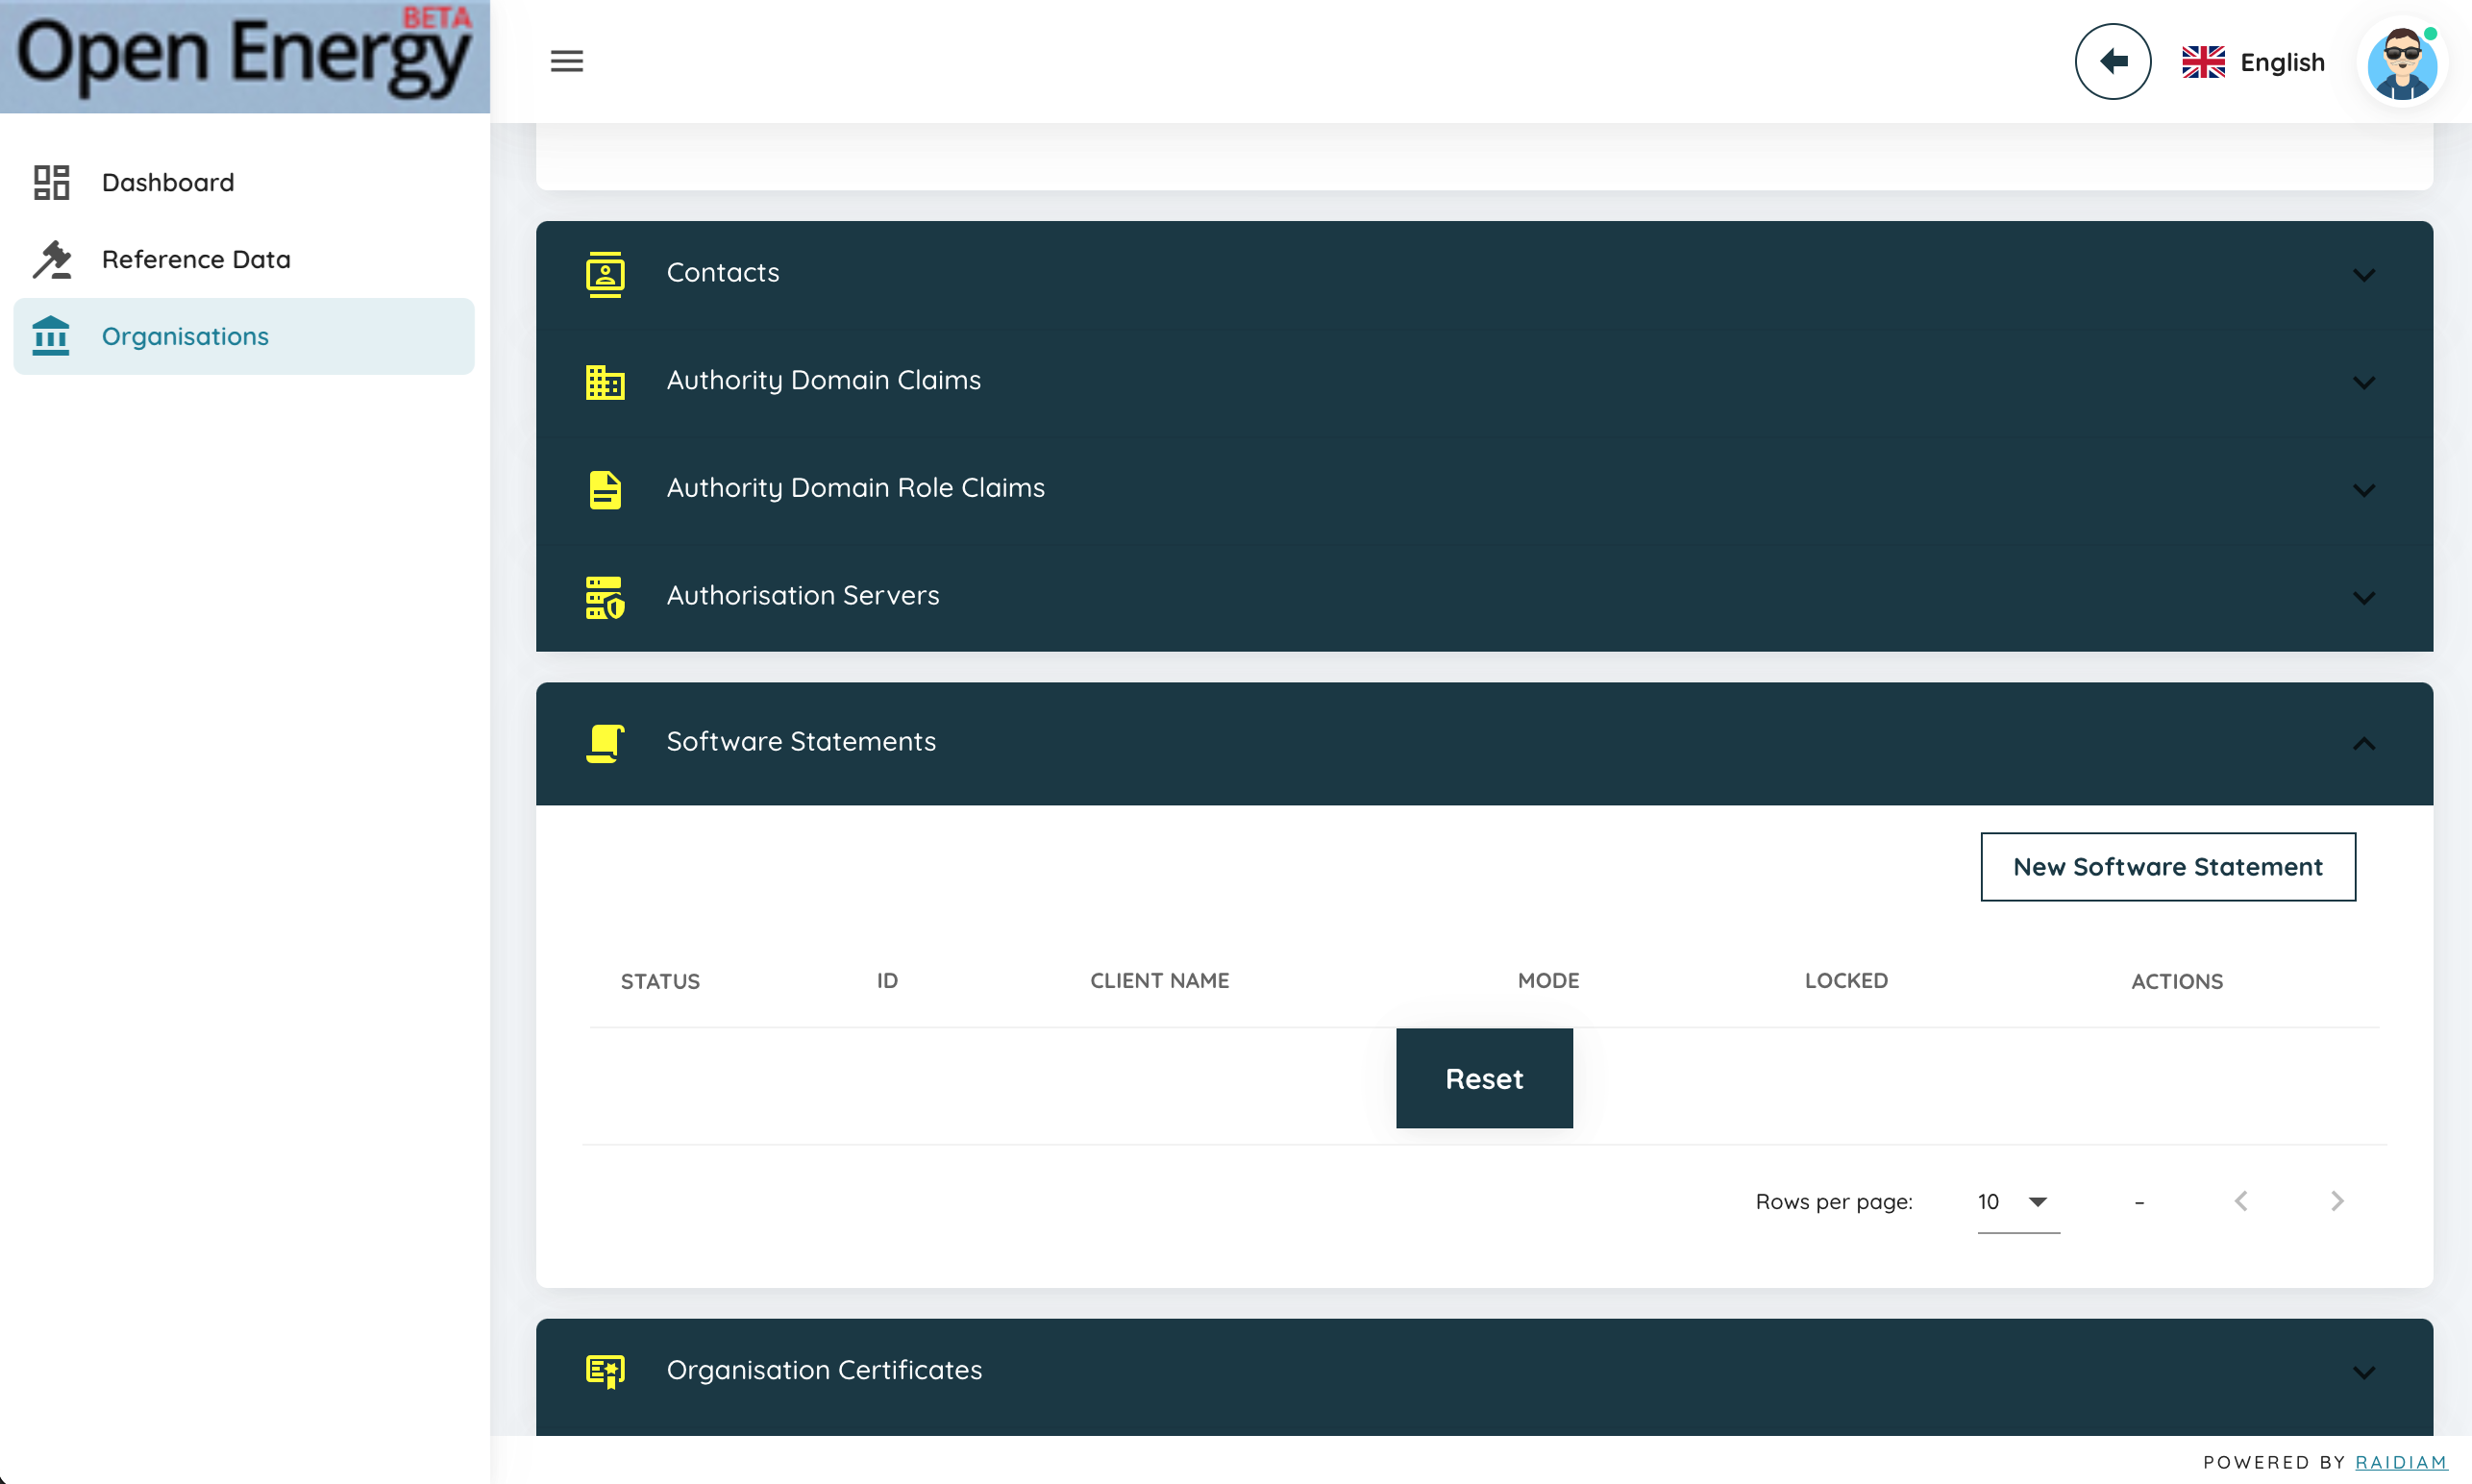

Press "New Software Statement" to get the popup
* Set MODE to Test
* Set VERSION to 1
* Set ENVIRONMENT to Test
* Set a suitably descriptive value for CLIENT NAME and DESCRIPTION
* It doesn’t matter what URI / URL you put in the other fields, but you have to put something in. The https://example.com is as good a choice as any - these are not used in Open Energy

Scroll down and click on the button to save your software statement.

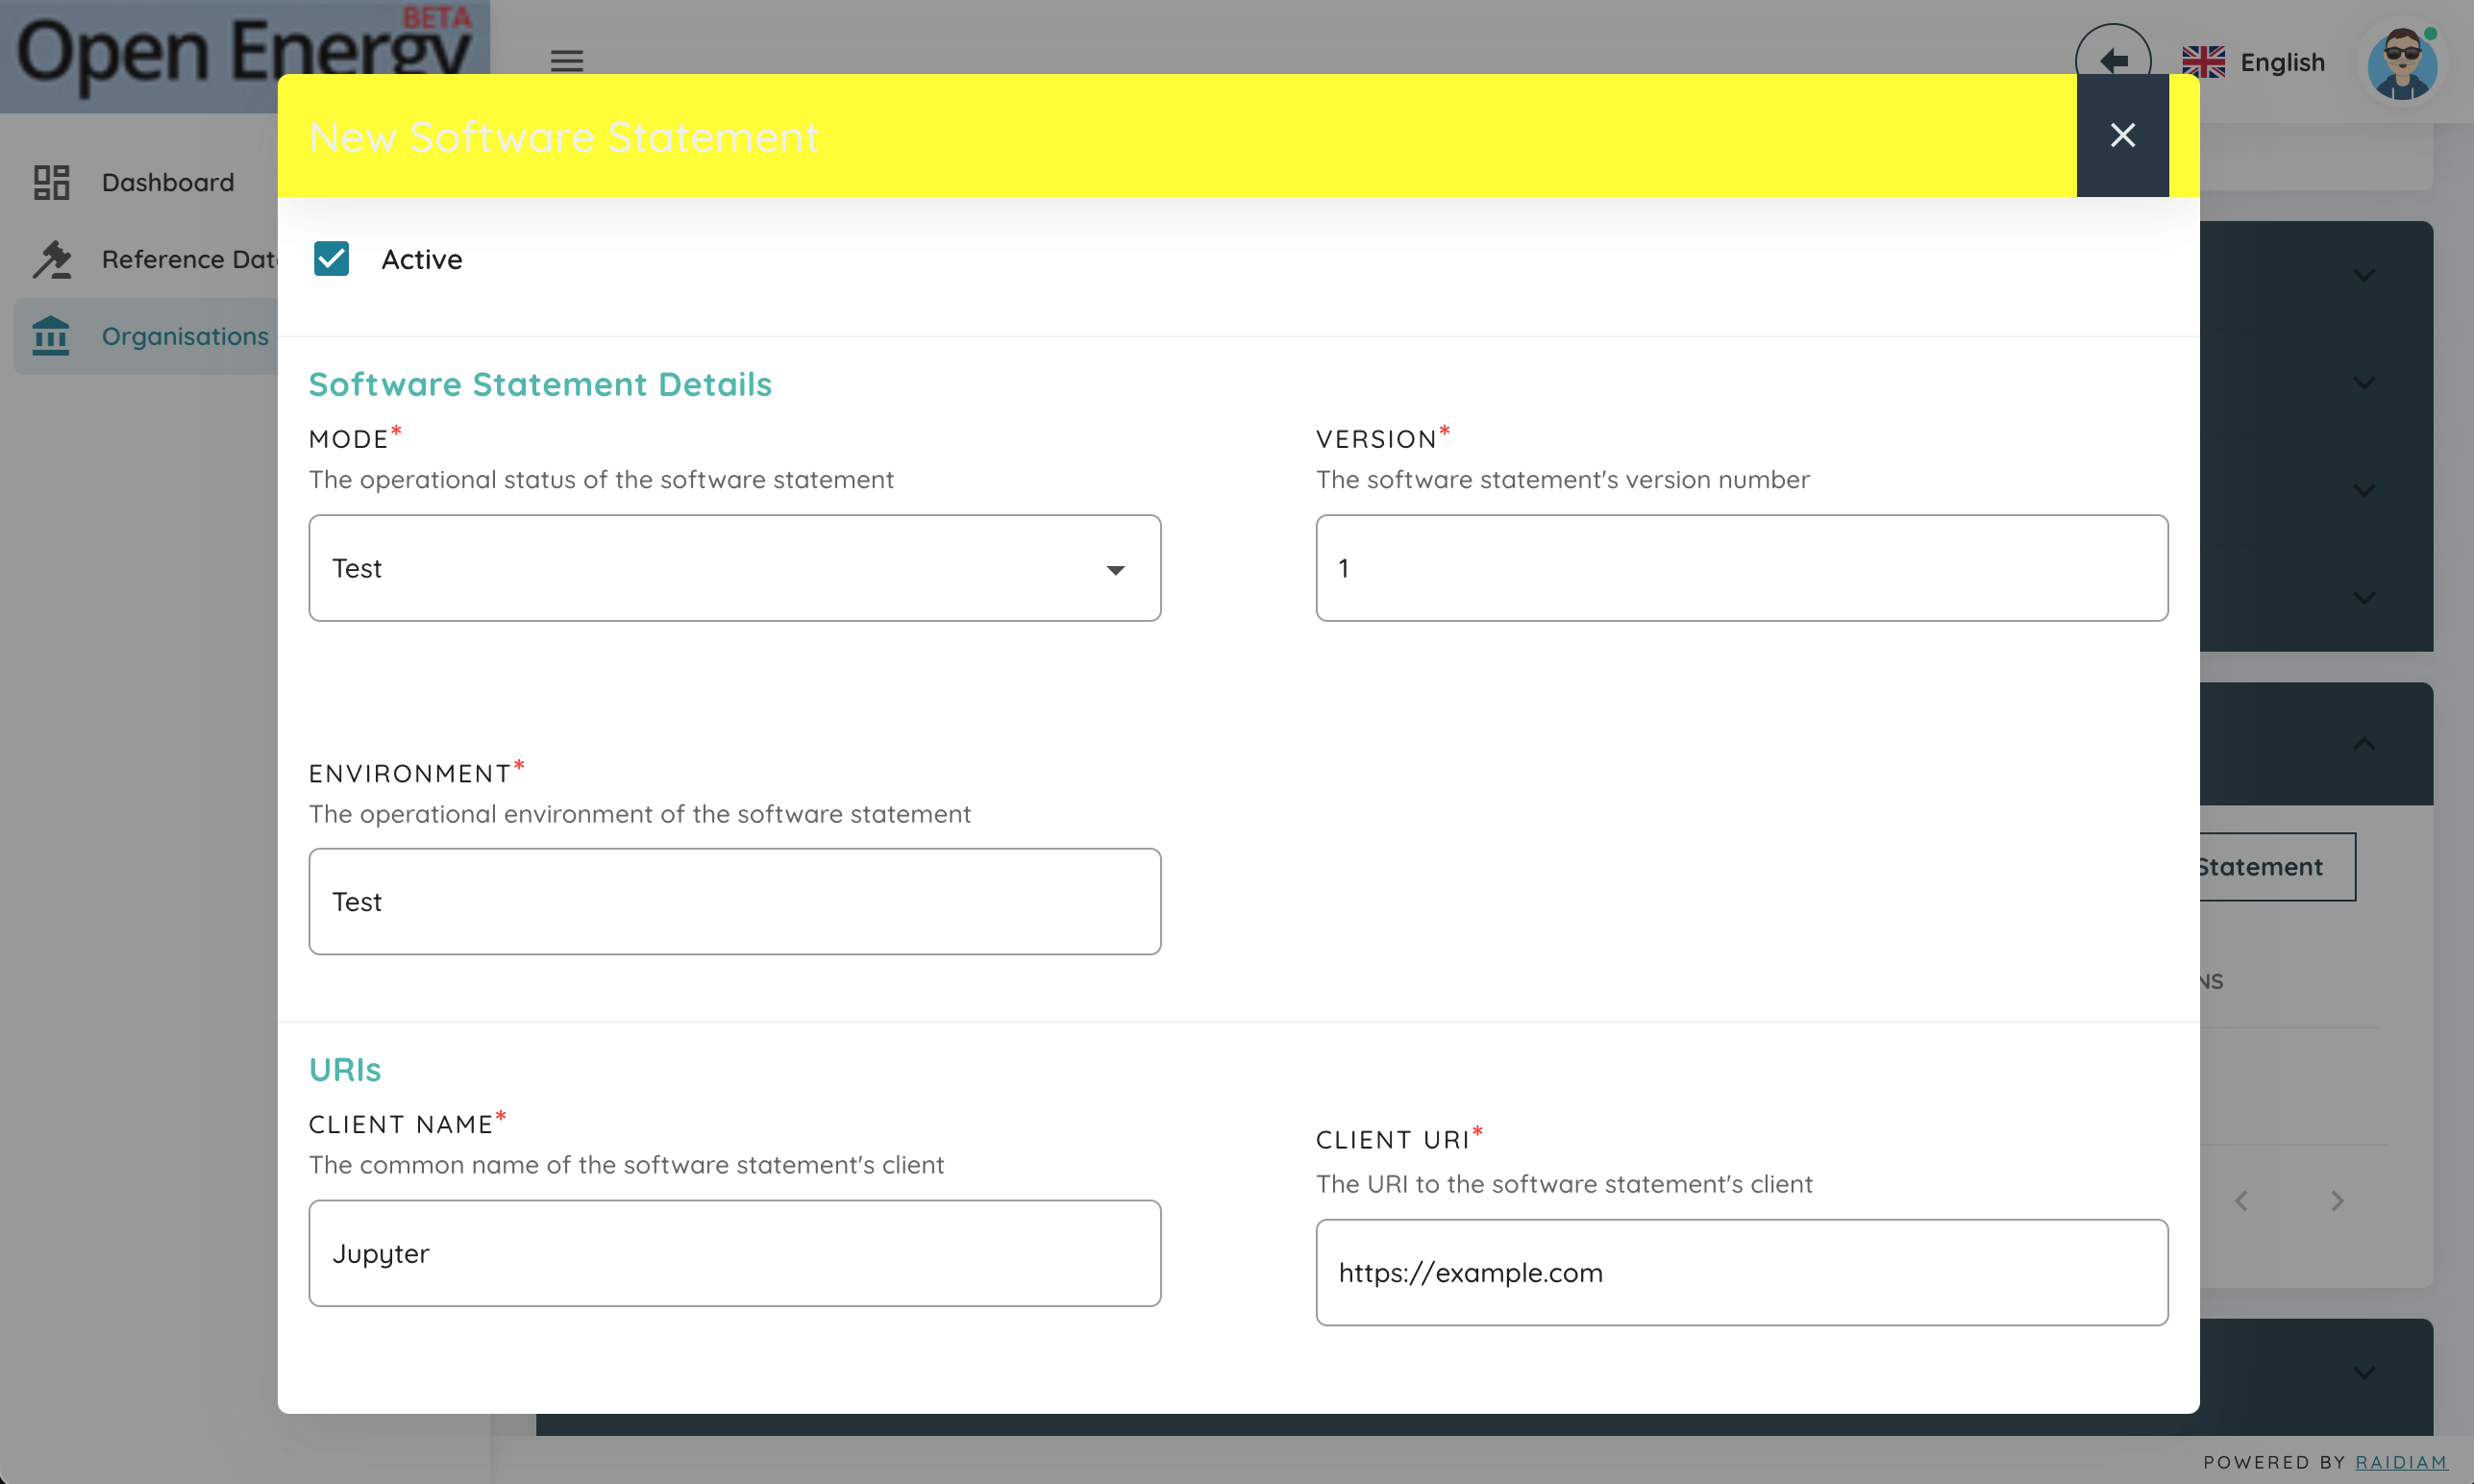

## Generate a private key and CSR

The Open Energy library includes a script - `oe_keygen` - that generates the private key and certificate signing request (CSR) you'll need to configure access to the directory.

In the code below, enter the Organisation ID from your directory entry (`jupyter-example` for this example) after `--organisation_unit`. 

Copy and paste the ID for your new Software Statement and fill it in after `--software_statement_id`

Leave `--organisation` as 'Open Energy'.

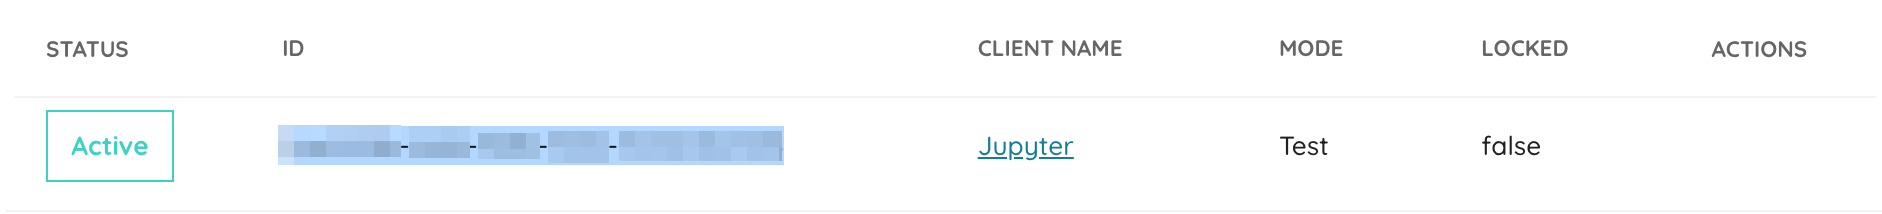

In [ ]:
!oe_keygen --organisation 'Open Energy' --organisation_unit 'jupyter-example' --software_statement_id '2ca5533b-4696-4080-9082-92747a34f433' 

## Download the CSR

The previous step created two files - `oe.key` and `oe.csr` in your notebook directory. Run the next code block to download `oe.csr` to your computer ready to provide it to the directory.

In [ ]:
from google.colab import files
files.download('oe.csr')

## Create the certificate

**Select the Software Statement you have just created** then scroll down to the Certificates section, open it, and press "New Certificate". 

*Note that there is an option to create an "Organisation Certificate" at the Organisation level that looks very similar to this, so make sure you're creating a certificate for the Software Statement - the dialog should say "New Certificate" not "New Organisation Certificate"*

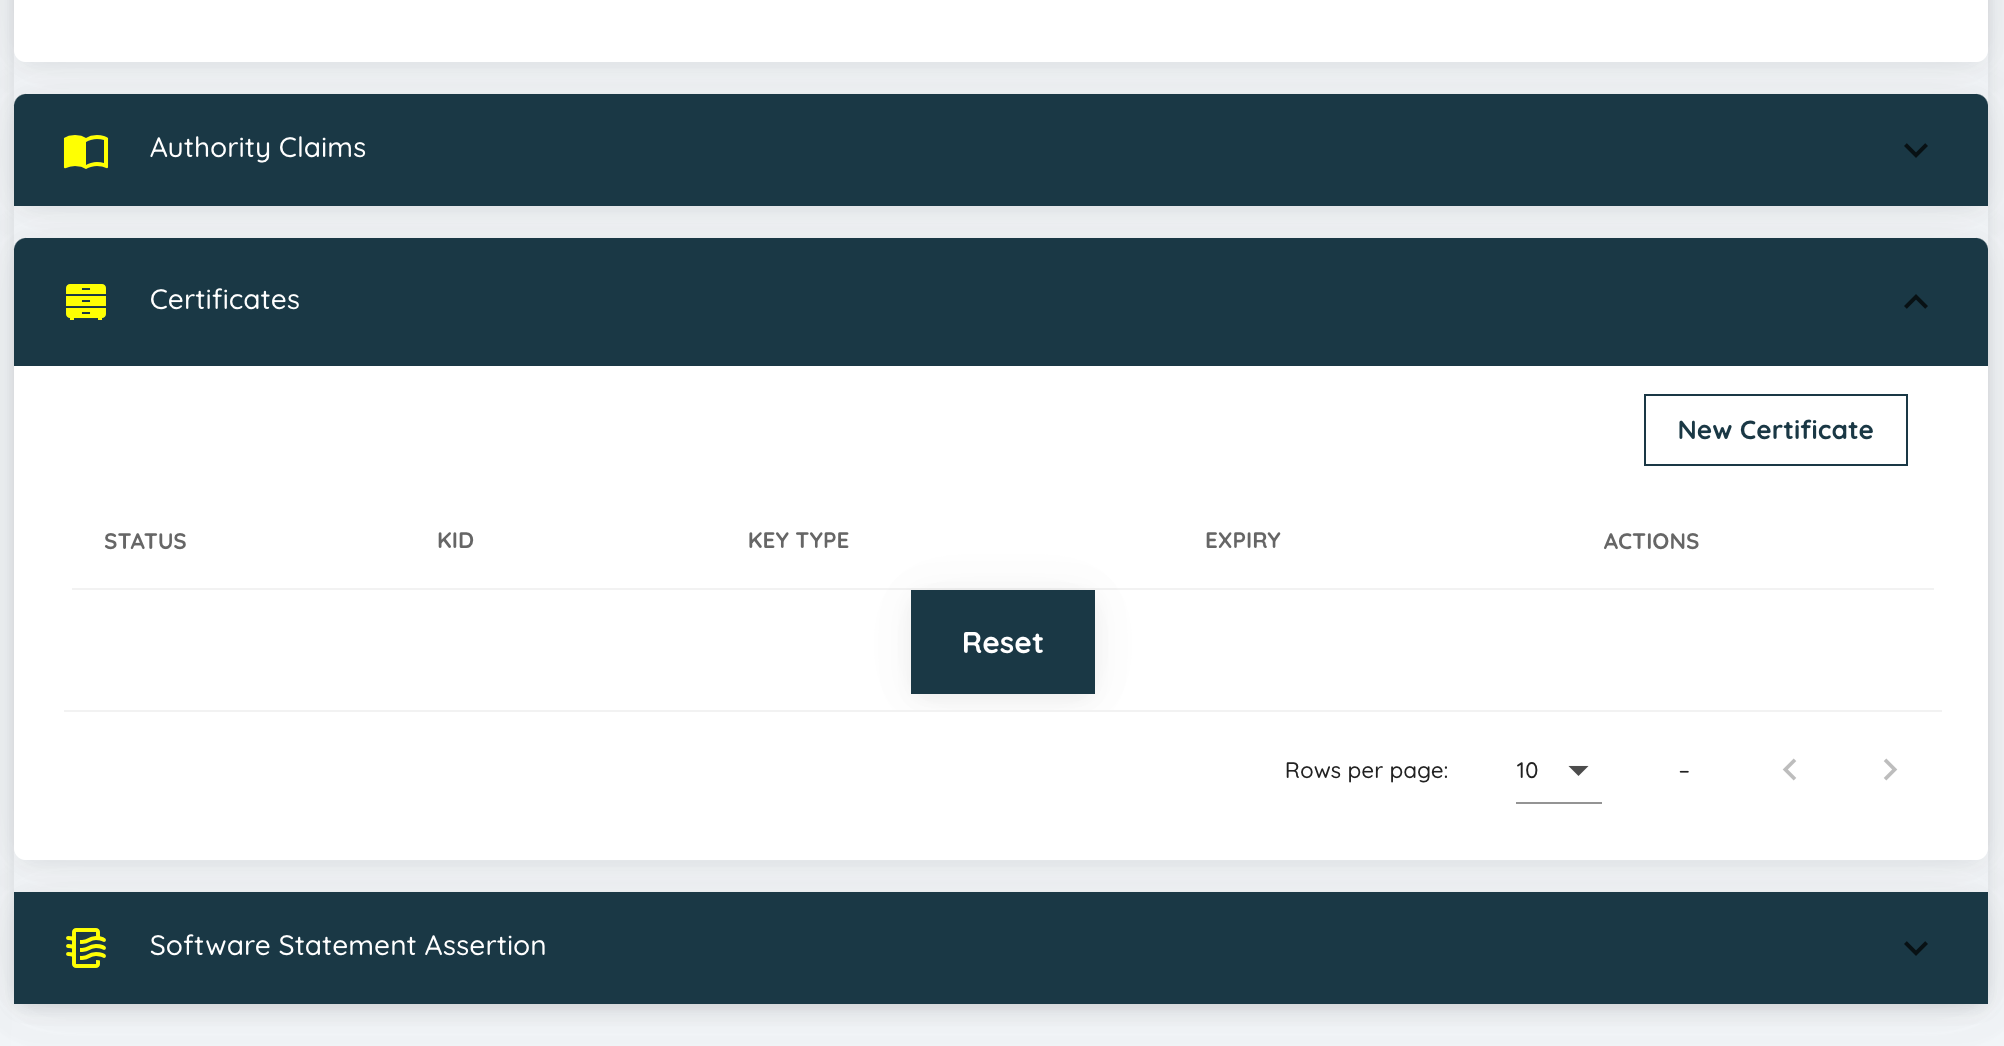

* In the popup, select TRANSPORT as the certificate type and press Continue.  



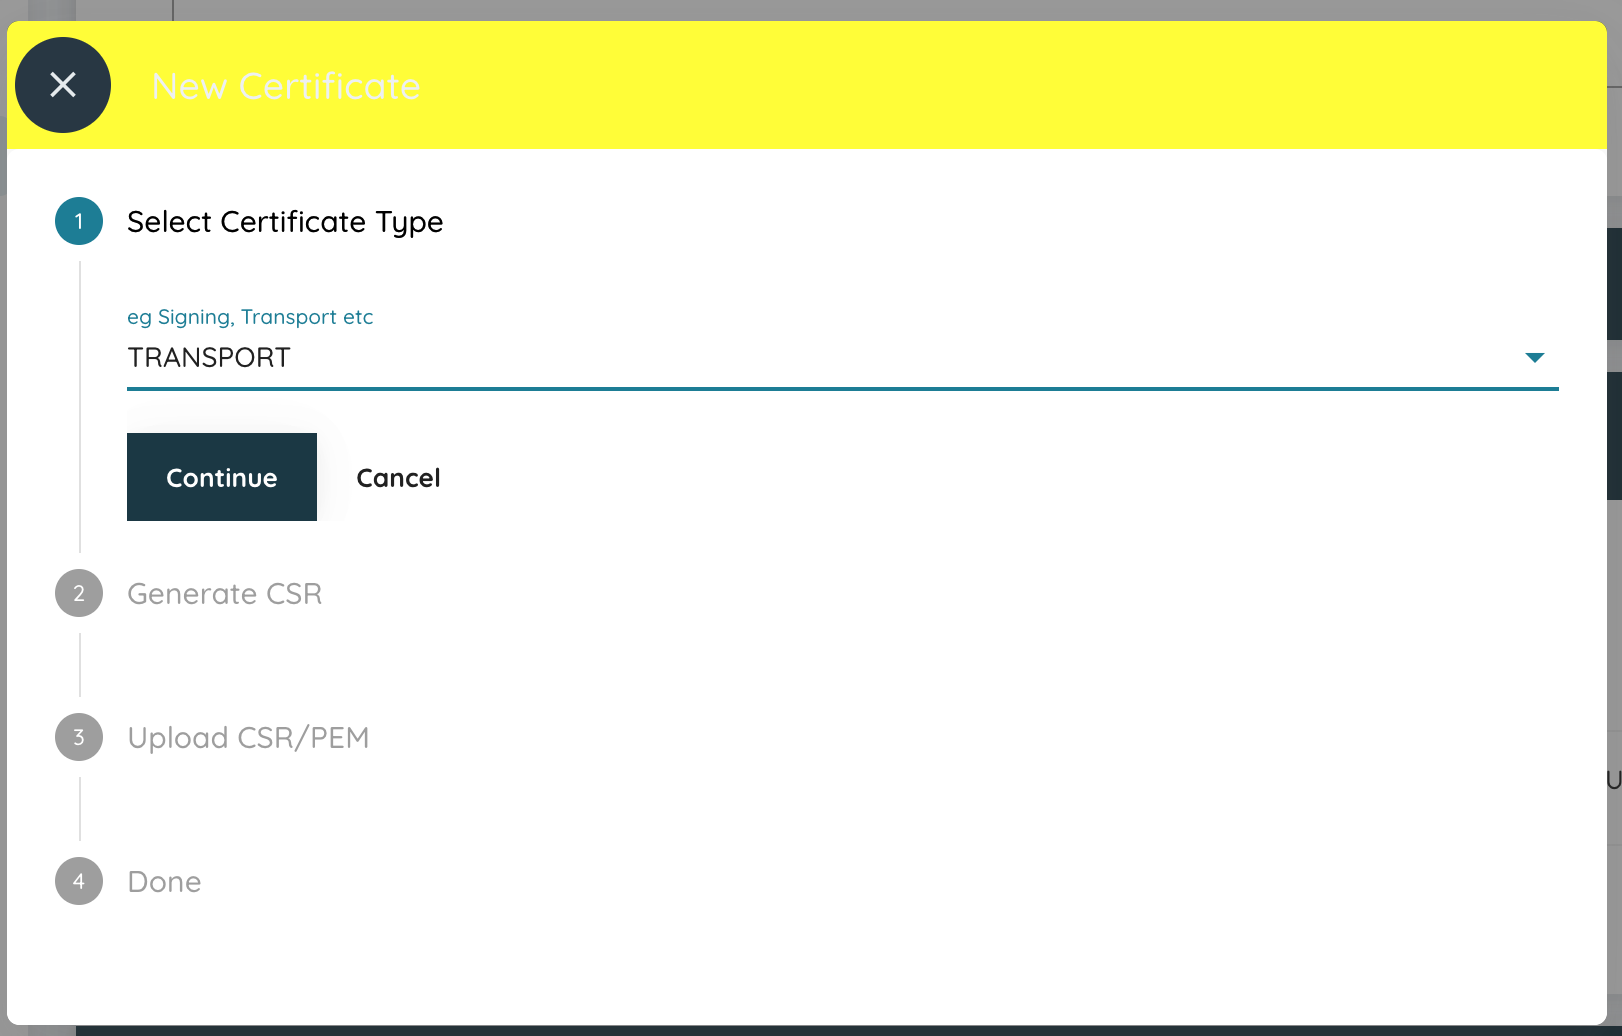

* Press Continue for Generate CSR (you don't need the command as already have the CSR you created earlier)

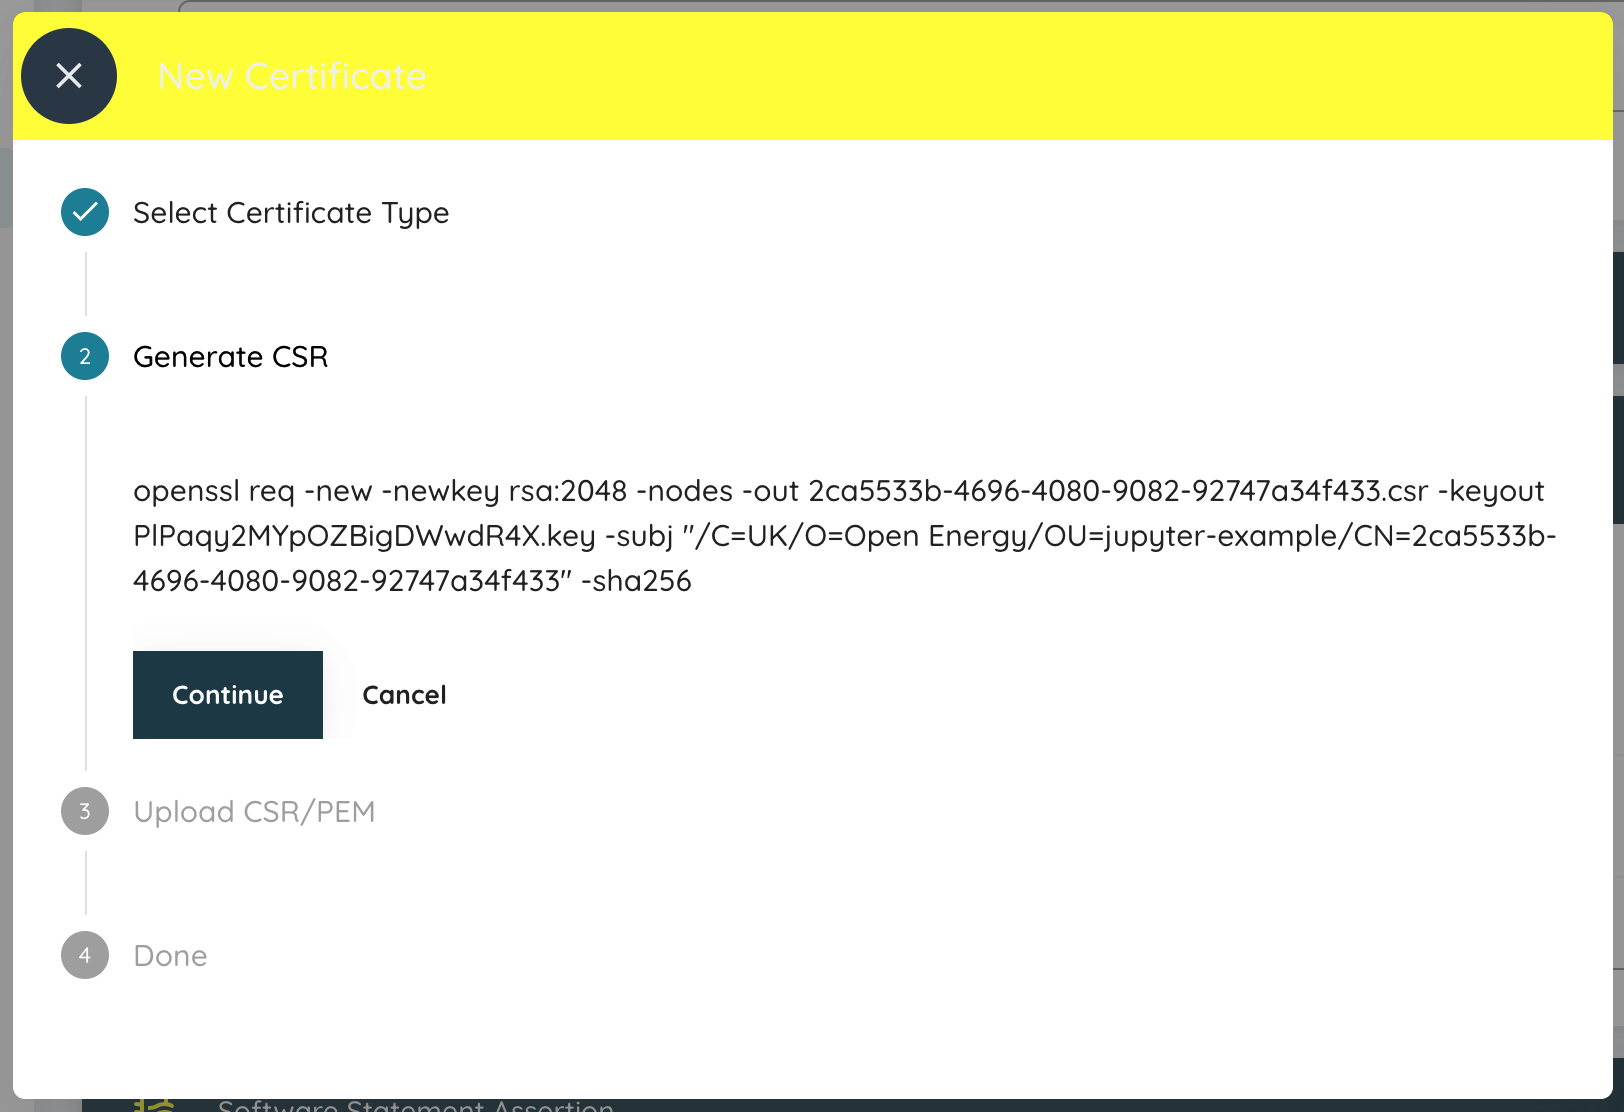

* Under Upload CSR/PEM press the paperclip button to upload the `oe.csr` file you downloaded earlier. Press Continue, then Done.

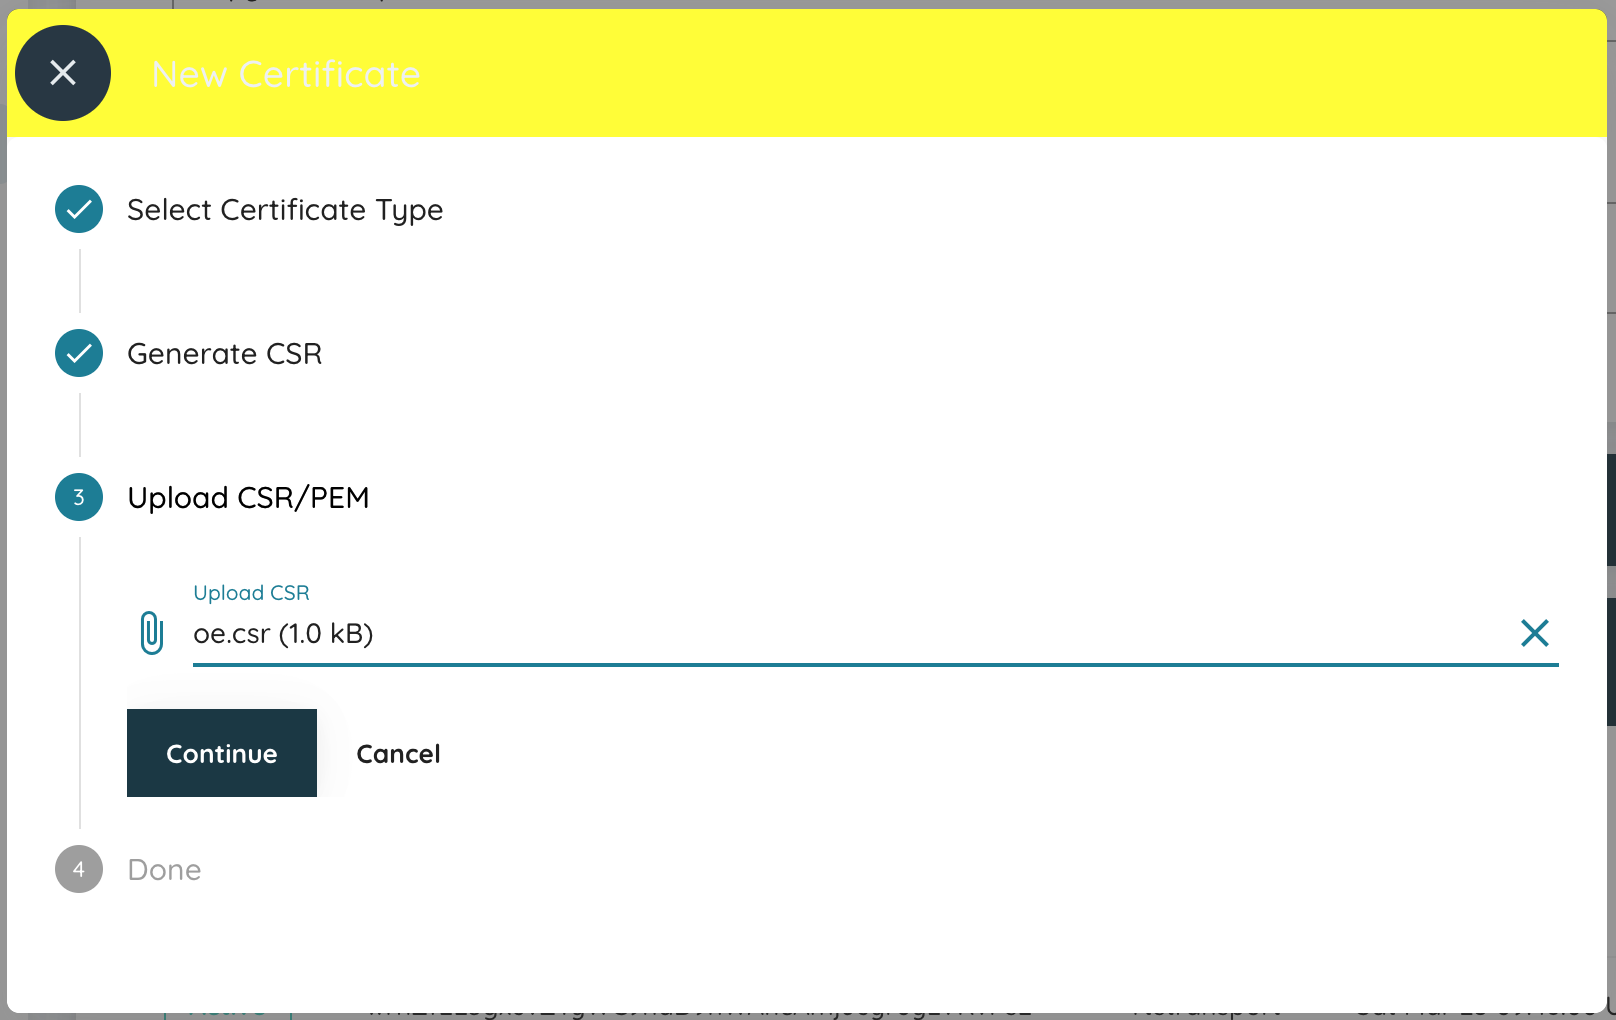

You should now see your newly minted certificate in the list. Use the small green arrow on the right to download the certificate to your local machine. You may want to rename it to `oe.pem` to match the files generated earlier.

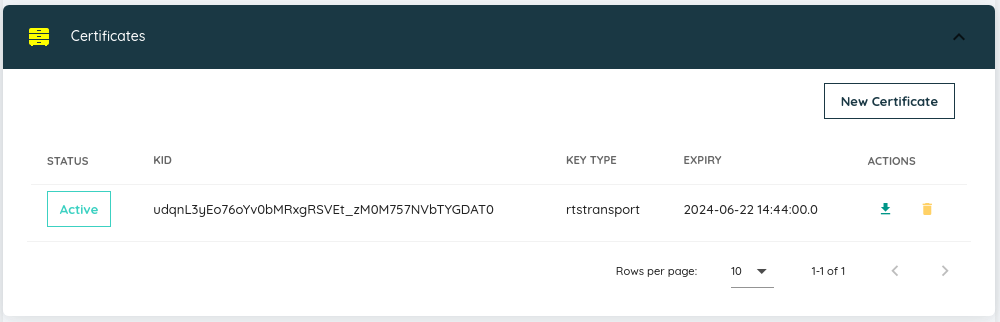

## Upload certificate

Run the block below, press Choose files, and select the certificate file you downloaded from the portal. This will upload it to the Python environment.

In [ ]:
files.upload()

If you refresh the file list on the left you should see all three files.

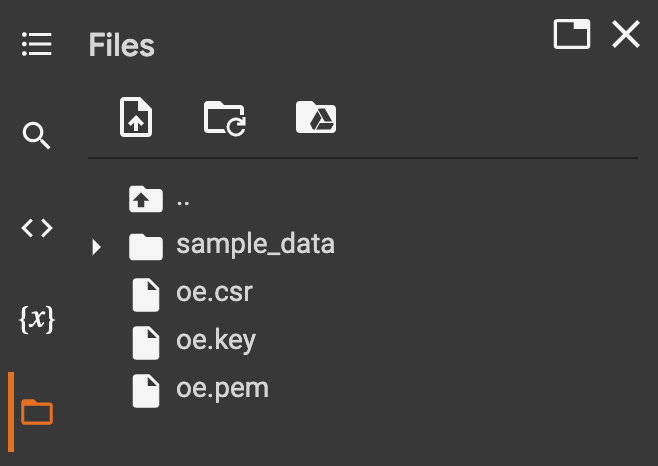

## Retrieve the Open ID client ID for your Software Statement

Go back to the portal and open the Software Statement you created earlier and copy the Client ID.

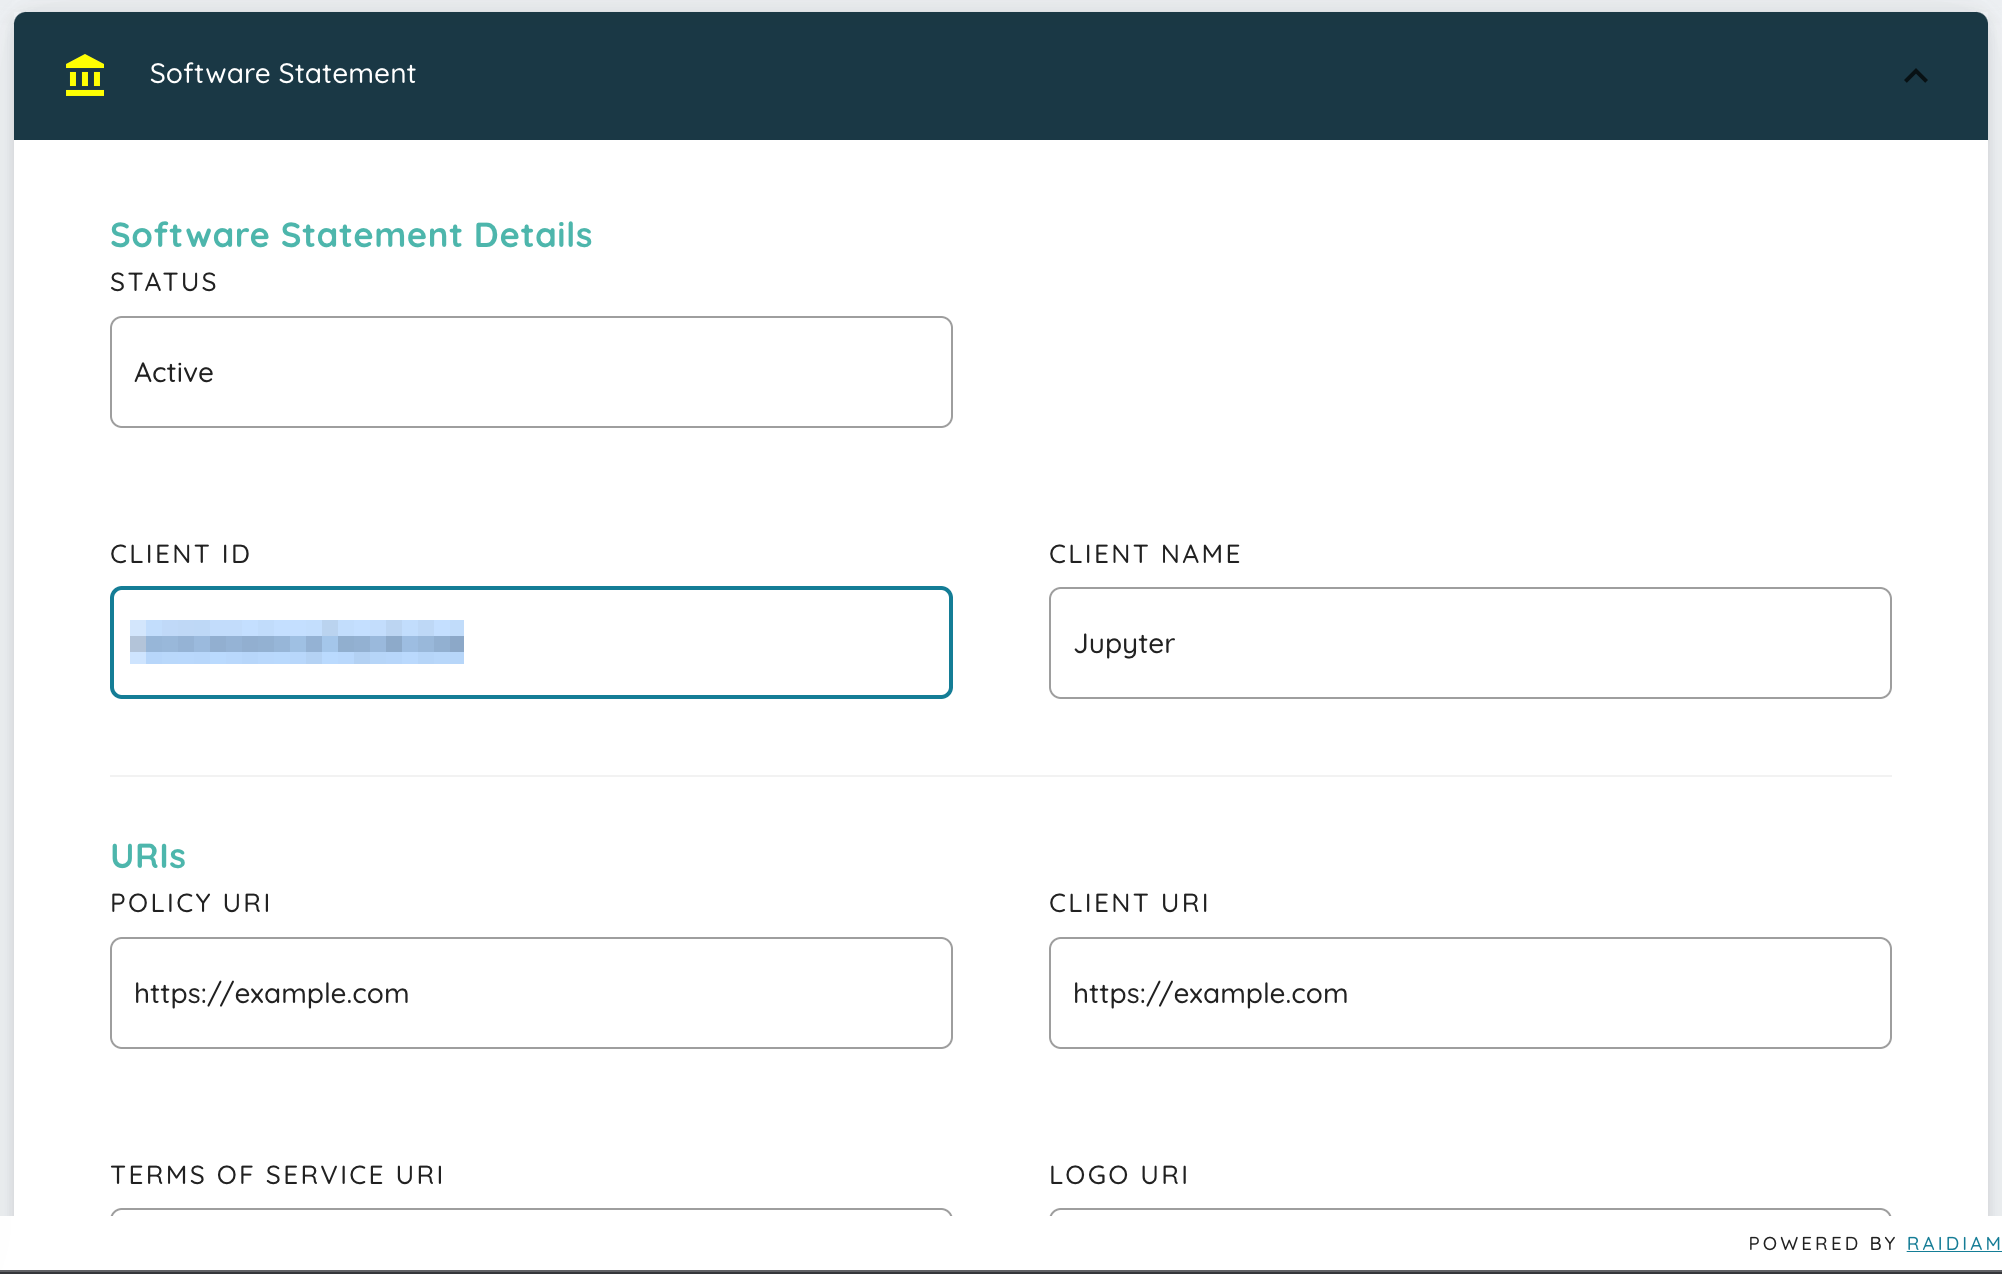



Paste the Client ID below and run the code


In [ ]:
client_id='replace_with_client_id'

## Take it for a spin

You can now use your new certificate to access a sample shared dataset that has only an `oe:verified` condition (the requester is a verified member of the Open Energy directory).

## Create a FAPI session

Open Energy uses the Financial API (FAPI) protocol for authentication, authorisation and security. The FAPISession object enables interaction with Open Energy secured resources by providing a [Requests](https://docs.python-requests.org/en/master/) session in `client.session` that automatically handles token negotiation using the credentials you provide.

In [ ]:
from ib1.openenergy.support import FAPISession

client = FAPISession(client_id=client_id,
                     issuer_url='https://matls-auth.directory.energydata.org.uk',
                     requested_scopes='directory:software',
                     private_key='oe.key',
                     certificate='oe.pem')

## Download a dataset

Note that visiting https://example.energydata.org.uk/tidy_DYTS01_kWh directly results in a 400 error.

In [ ]:
import io
import pandas as pd

dataset_url = 'https://example.energydata.org.uk/tidy_DYTS01_kWh'
csv_data = client.session.get(url=dataset_url).text

df = pd.read_csv(io.StringIO(csv_data)) 
display(df)

## Saving your key and certificate for use in other notebooks

Google Colab will clear any local storage when your session expires, and the files you have generated will be lost. There are [several options](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) for saving your files in Google Colab. Other Jupyter environments may provide keystores or file systems you can use.

We'll save the files to your Google Drive. Our other example notebooks assume you have done this. 

First, mount your Jupyter environment to your Drive. This will pop up a warning and then take you through a standard permissioning flow to allow access to your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [Google Drive](https://drive.google.com), navigate to `My Drive` and create a folder called `oe-certs`.

Run the code below to copy the key and certificate there (the CSR is no longer needed)

In [ ]:
from shutil import copyfile
copyfile('oe.key','/content/drive/MyDrive/oe-certs/oe.key')
copyfile('oe.pem','/content/drive/MyDrive/oe-certs/oe.pem')
with open('/content/drive/MyDrive/oe-certs/client_id.txt', 'w', newline='') as f:
  f.write(client_id)

!ls /content/drive/MyDrive/oe-certs

## Unmount drive and flush changes


In [ ]:
drive.flush_and_unmount()